In [126]:
import os, importlib, sys, time

In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [128]:
import scipy.linalg as la
import scipy.stats as stats

In [129]:
import pyarrow

# 1. parameters

In [130]:
T = 120
T0 = 40

In [131]:
GPi = np.load('data/GPi.npz')

## observation parameters

In [132]:
pi = np.zeros(T+T0)
# pi[:min(GPi['pi'].shape[0], T+T0)] = GPi['pi'][:min(GPi['pi'].shape[0], T+T0)]
pi[0] = 1

$$Y_t = NegBinom( \frac{EY_t}{r_Y + EY_t}, r_Y )$$

$$ EY_t = \alpha\sum_{s=1}^{t-1} I_s \pi_{t-s} $$

## latent parameters

In [133]:
g = np.zeros(T+T0)
g[:min(GPi['g'].shape[0], T+T0)] = GPi['g'][:min(GPi['g'].shape[0], T+T0)]

In [134]:
d = 3
## order: 1, U, X, A, I
alpha = np.array([0, 0.2, 0, 1, 0])
# beta = np.array([-np.log(5.5), -0.05, 0, 0, 0])
gamma = np.array([-2.5, 0, 0, 4, 0.001])
phi = 0.95

In [135]:
betas = np.array([
    np.linspace(-np.log(5.5), -np.log(5.5)+0.5, 21),     
    np.linspace(0.3, 0.3, 21),
    np.linspace(0, 0, 21),
    np.linspace(0, -1, 21),
    np.linspace(0, 0, 21)
]).T

In [136]:
K = 6.5
r_I = 10

$$I_t = NegBinom( \frac{EI_t}{r_I + EI_t}, r_I )$$

$$ EI_t = R(\bar{A}_t, \beta) \sum_{s=1}^{t-1} I_s g_{t-s} $$

$$R(\bar{A}_t, \beta) = \frac{K}{1+\exp(- \beta^\top A_t)}$$

## seed values

In [137]:
mu = np.log(100)

$$I_{-T_0} = \mu_0$$

# 2. simulation

In [138]:
num_sim = 100

## random seed

In [139]:
np.random.seed(1234)

## data generation

In [140]:
Pi = np.concatenate([[0],pi])[np.maximum(0, np.arange(T)[:,None] - np.arange(T))]
Pi0 = np.concatenate([[0],pi])[np.maximum(0, np.arange(T)[:,None] - np.arange(-T0,0))]

In [141]:
G = np.concatenate([[0],g])[np.maximum(0, np.arange(T)[:,None] - np.arange(T))]
G0 = np.concatenate([[0],g])[np.maximum(0, np.arange(T)[:,None] - np.arange(-T0,0))]

In [142]:
I0 = np.full(T0, np.exp(mu))

In [143]:
for iter_beta, beta in enumerate(betas):
    U = np.random.multivariate_normal(
        np.zeros(T), phi ** np.abs(np.arange(T)[:,None] - np.arange(T)), num_sim)
    X = np.zeros((num_sim, T))
    EA = np.zeros((num_sim, T))
    A = np.zeros((num_sim, T))
    R = np.zeros((num_sim, T))
    EI = np.zeros((num_sim, T))
    I = np.zeros((num_sim, T))
    EY = np.zeros((num_sim, T))
    Y = np.zeros((num_sim, T))

    X[:,0] = alpha[0] + alpha[1]*U[:,0] + np.random.normal(0,0.3,num_sim)
    EA[:,0] = 0
    A[:,0] = np.random.binomial(1, EA[:,0])
    R[:,0] = K / (1 + np.exp(- beta[0] - beta[1] * U[:,0] - beta[2] * X[:,0] - beta[3] * A[:,0]))
    EI[:,0] = R[:,0] * (G0[0] @ I0 + G[0,:0] @ I[:,:0].T)
    I[:,0] = np.random.negative_binomial(r_I, r_I/(r_I+EI[:,0]))
    EY[:,0] = Pi0[0] @ I0 + Pi[0,:0] @ I[:,:0].T
    Y[:,0] = EY[:,0]

    for t in np.arange(1,T):
        X[:,t] = (alpha[0] + alpha[1]*U[:,t] + alpha[2]*X[:,t-1] 
                  + alpha[3]*A[:,t-1] + alpha[4]*Y[:,t-1] + np.random.normal(0,0.3,num_sim))
        EA[:,t] = 1 - 1/(1 + np.exp(np.clip(
            gamma[0] + gamma[1]*U[:,t] + gamma[2]*X[:,t] + gamma[3]*A[:,t-1] + gamma[4]*Y[:,t-1],
            -4, 4
        )))
        A[:,t] = np.random.binomial(1, EA[:,t])
        R[:,t] = K / (1 + np.exp(- beta[0] - beta[1]*U[:,t] - beta[2]*X[:,t] 
                                 - beta[3]*A[:,t] - beta[4]*Y[:,t-1]))
        EI[:,t] = R[:,t]*(G0[t]@I0 + G[t,:t]@I[:,:t].T)
        I[:,t] = np.random.negative_binomial(r_I, r_I/(r_I+EI[:,t]))
        EY[:,t] = Pi0[t]@I0 + Pi[t,:t]@I[:,:t].T
        Y[:,t] = EY[:,t]

    data = {'sim': np.tile(np.arange(num_sim)[:,None], (1,T)).flatten(),
            'date': np.tile(np.arange(T), (num_sim,1)).flatten(),
            'phantom': U.flatten(),
            'covariate': X.flatten(),
            'EA': EA.flatten(),
            'intervention': A.flatten(),
            'R': R.flatten(),
            'EI': EI.flatten(),
            'infection': I.flatten(),
            'EY': EY.flatten(),
            'death': Y.flatten()}

    df = pd.DataFrame(data)
    df.to_feather('data/simulation_phantom_null_%.2d.feather'%iter_beta)

# 3. check data

In [144]:
iter_beta = 20
iter_sim = 10

In [145]:
data = pd.read_feather('data/simulation_phantom_null_%.2d.feather'%iter_beta)

In [146]:
I = data["infection"].to_numpy().reshape([num_sim, T])

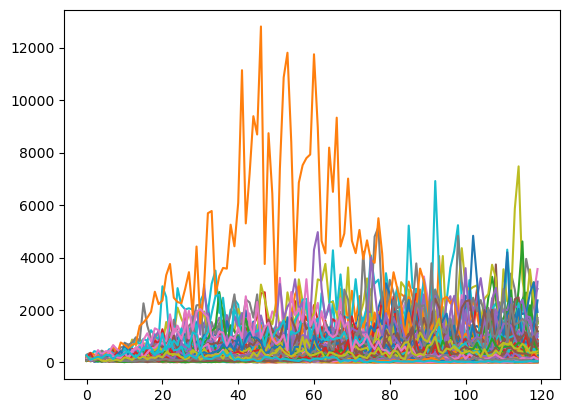

In [147]:
plt.plot(I.T)
plt.show()

In [148]:
data_i = data[data['sim']==iter_sim]
A = np.stack([np.full(T, 1), data_i["covariate"].to_numpy(), 
              data_i["intervention"].to_numpy()], -1)
R = data_i.R.values
Y = data_i["death"].to_numpy()

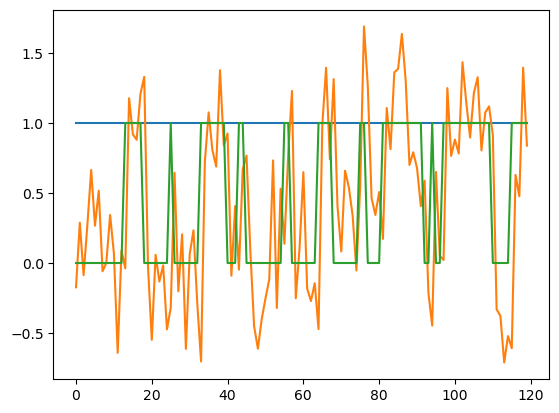

In [149]:
plt.plot(A)

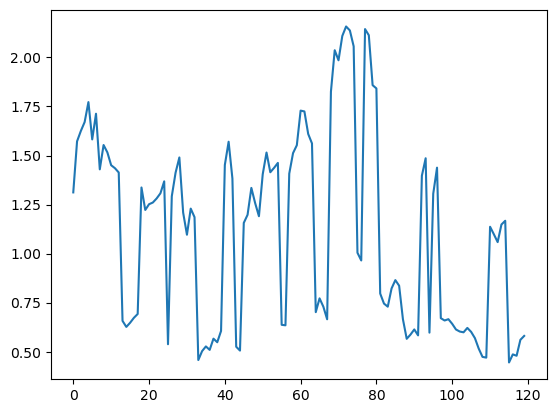

In [150]:
plt.plot(R)

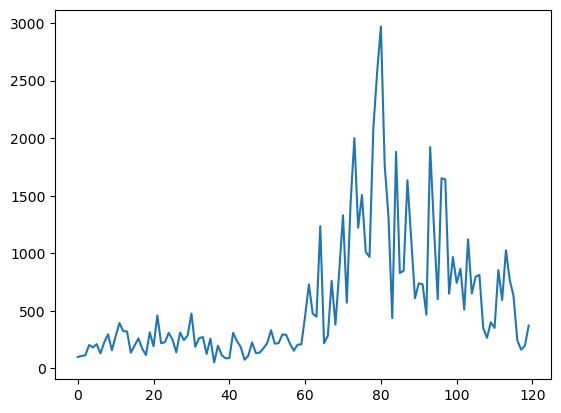

In [151]:
plt.plot(Y)